In [43]:
!pip install -q navec nltk  swifter
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2024-12-09 20:13:55--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.4’

00q.tar.4            97%[==================> ]  49.12M  1.97MB/s    eta 1s     ^C


In [4]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from nltk.corpus import stopwords
import nltk
import swifter
import pymorphy3
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from navec import Navec
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score

In [45]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [46]:
navec['привет'].shape

(300,)

In [47]:
!ls

1.ipynb
2.ipynb
3.ipynb
bow_matrix.npz
bow_output.csv
lemmatized_texts.pkl
navec_hudlit_v1_12B_500K_300d_100q.tar
navec_hudlit_v1_12B_500K_300d_100q.tar.1
navec_hudlit_v1_12B_500K_300d_100q.tar.2
navec_hudlit_v1_12B_500K_300d_100q.tar.3
navec_hudlit_v1_12B_500K_300d_100q.tar.4
news.csv
vectorizer.pkl


In [5]:
news_data = pd.read_csv("news.csv", delimiter=";")

In [6]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
nltk.   download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = pymorphy3.MorphAnalyzer()

def lemmatize(doc, return_list=False):
    if not isinstance(doc, str):  # Проверяем, является ли входной текст строкой
        return ""

    doc = re.sub(patterns, ' ', doc)
    tokens = []
    
    for token in doc.split():
        token = token.strip()
        
        if token and token not in stopwords_ru and token[0] != '@' and not token.isascii():
            normal_forms = morph.normal_forms(token)
            if len(normal_forms) > 0:
                token = normal_forms[0]
            tokens.append(token)
    
    if len(tokens) > 0:
        return tokens if return_list else ' '.join(tokens)
    
    return ""

[nltk_data] Downloading package stopwords to /Users/duke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
news_data["content_lem"] = news_data["content"].apply(lambda x: lemmatize(x))

In [51]:
news_data["tags"].value_counts(normalize=True)[:40].values.sum()

np.float64(0.8220391669257072)

In [54]:
def vectorize(sentence, model):
    texts_vectorized = 0
    #model_keys = [key.split("_")[0] for key in list(russian_model.key_to_index.keys())]
    if sentence is None or sentence is np.nan:
      return np.zeros(300)
    else:
      texts_vectorized += 1
      words = sentence.split()
      #print("sentence len: ", len(words))
    words_vecs = [model[word] for word in words if word in model]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

vectorized_news = np.array([vectorize(sentence, navec) for sentence in news_data["content_lem"]])

In [55]:
vectorized_news.shape

(8607, 300)

In [56]:
def plot_elbow_rule(X, K=40):
  values = []
  for k in range(1, K):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    value = np.array([((X[labels == i, :] - centers[i, :]) ** 2).sum(axis=1).sum() for i in range(k)])
    values.append(value.sum())
  plt.plot(values)
  plt.show()

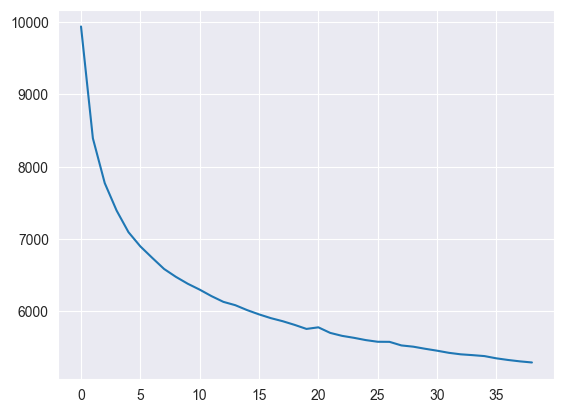

In [57]:
plot_elbow_rule(vectorized_news)

In [58]:
kmeans = KMeans(n_clusters=5, random_state=42)
pca = PCA(random_state=42)

In [59]:
X_train, X_test = train_test_split(vectorized_news, train_size=0.85, random_state=42)

In [60]:
kmeans.fit(X_train)

KMeans(n_clusters=5, random_state=42)

In [61]:
y_pred = kmeans.predict(X_test)
y_train = kmeans.predict(X_train)
print("train score: ", silhouette_score(X_train, y_train))
print("test score: ", silhouette_score(X_test, y_pred))

train score:  0.1291335389726412
test score:  0.13454517838868818


In [62]:
print("train score: ", davies_bouldin_score(X_train, y_train))
print("test score: ", davies_bouldin_score(X_test, y_pred))

train score:  2.3715298580702475
test score:  2.344613293646539


классическиt методы векторизации + еще одна внутреннюю метрику Calinski-Harabasz Index

In [63]:
news_data

,id,source_type,title,content,link,date,tags,post_links,source_link,source_name,content_lem
0,1,dzen,Количество раненых при нападении на магазин в ...,Число пострадавших при нападении посетителя с ...,https://dzen.ru/news/story/45396279-888c-507f-...,10/25/24 14:30,index,"['https://vz.ru/news/2024/10/25/1294420.html',...",https://vz.ru/news/2024/10/25/1294420.html,vz,число пострадать нападение посетитель нож мага...
1,2,dzen,Набиуллина: ипотечные ставки начнут снижаться ...,"""По мере снижения инфляции ипотечные ставки бу...",https://dzen.ru/news/story/1c02c1ba-4c7d-5c07-...,10/25/24 15:49,index,['https://realty.ria.ru/20241025/stavki-198010...,https://realty.ria.ru/20241025/stavki-19801093...,ria,по мера снижение инфляция ипотечный ставка быт...
2,3,dzen,RT выяснил личность подозреваемого в рабовладе...,"Как удалось выяснить, фигурант дела — 40-летни...",https://dzen.ru/news/story/3e598c32-677a-5e33-...,10/25/24 15:20,index,['https://russian.rt.com/russia/news/1387351-l...,https://russian.rt.com/russia/news/1387351-lic...,russian.rt,как удаться выяснить фигурант дело летний урож...
3,4,dzen,ТАСС: войска Украины пытаются покинуть Селидово,Подразделения Вооруженных сил Украины (ВСУ) пр...,https://dzen.ru/news/story/f7ba2bed-7abf-506c-...,10/25/24 15:03,index,['https://lenta.ru/news/2024/10/25/stalo-izves...,https://lenta.ru/news/2024/10/25/stalo-izvestn...,lenta,подразделение вооружённый сила украина всу про...
4,5,dzen,Умер режиссер первых серий «Улиц разбитых фона...,Российский режиссер и сценарист Игорь Москвити...,https://dzen.ru/news/story/f7ebd12d-543d-5214-...,10/25/24 14:52,index,"['https://www.kommersant.ru/doc/7263953', 'htt...",https://www.kommersant.ru/doc/7263953,kommersant,российский режиссёр сценарист игорь москвитин ...
...,...,...,...,...,...,...,...,...,...,...,...
8602,7774,fomag,Юань стабилен: сильный доллар нивелирует оптим...,(Рейтер) рост доллара ввиду напряженности на Б...,https://fomag.ru/news-streem/yuan_stabilen_sil...,10/19/23 11:16,NaN,NaN,NaN,Reuters,рейтер рост доллар ввиду напряжённость ближний...
8603,7774,fomag,ЮГК стремится устранить все нарушения в коротк...,"МОСКВА, 14 августа. /ТАСС/. ""Южуралзолото ГК"" ...",https://fomag.ru/news-streem/yugk-stremitsya-u...,8/14/24 10:04,NaN,NaN,NaN,tass,москва август тасс южуралзолото гк югк пока по...
8604,7775,fomag,Южуралзолото установила диапазон размещения IP...,(Рейтер) Российский золотодобытчик Южуралзолот...,https://fomag.ru/news-streem/yuzhuralzoloto_us...,11/13/23 9:54,NaN,NaN,NaN,Reuters,рейтер российский золотодобытчик южуралзолото ...
8605,7775,fomag,"Ян Арт про банковские вклады, облигации, золот...","Ключевую ставку ЦБ, конфликт на Ближнем Восток...",https://fomag.ru/news/yan-art-pro/,10/25/23 11:59,NaN,NaN,NaN,NaN,ключевой ставка цб конфликт ближний восток мно...


In [64]:
df_t_c = news_data[['title', 'content_lem']].copy()
df_t_c

,title,content_lem
0,Количество раненых при нападении на магазин в ...,число пострадать нападение посетитель нож мага...
1,Набиуллина: ипотечные ставки начнут снижаться ...,по мера снижение инфляция ипотечный ставка быт...
2,RT выяснил личность подозреваемого в рабовладе...,как удаться выяснить фигурант дело летний урож...
3,ТАСС: войска Украины пытаются покинуть Селидово,подразделение вооружённый сила украина всу про...
4,Умер режиссер первых серий «Улиц разбитых фона...,российский режиссёр сценарист игорь москвитин ...
...,...,...
8602,Юань стабилен: сильный доллар нивелирует оптим...,рейтер рост доллар ввиду напряжённость ближний...
8603,ЮГК стремится устранить все нарушения в коротк...,москва август тасс южуралзолото гк югк пока по...
8604,Южуралзолото установила диапазон размещения IP...,рейтер российский золотодобытчик южуралзолото ...
8605,"Ян Арт про банковские вклады, облигации, золот...",ключевой ставка цб конфликт ближний восток мно...


In [65]:
df_t_c['content_lem'].head(1)

0    число пострадать нападение посетитель нож мага...
Name: content_lem, dtype: object

In [66]:
df_t_c['text'] = df_t_c['title'] + '. ' + df_t_c['content_lem']
df_t_c.loc[:, 'text'] = df_t_c['text'].apply(lambda x: str(x).lower())
df_t_c['text'][0]

'количество раненых при нападении на магазин в петербурге выросло до пяти человек. число пострадать нападение посетитель нож магазин «окей» проспект космонавт петербург увеличиться пять сообщить пресс служба комитет здравоохранение город «четверо пациент тяжёлый состояние состояние средний степень тяжесть доставить городской больница № нии скорый помощь имя джанелидзе» – говориться сообщение подозревать задержать место преступление сам нападать также доставить медицинский учреждение'

In [67]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

pattern = r'[^\w\s]'

def preprocess_text(df: pd.Series) -> pd.Series:
    df = df.apply(lambda x: re.sub(pattern, '', str(x)))
    df_ = df.apply(lambda x: word_tokenize(x, language='russian'))
    stop_words = set(stopwords.words('russian'))
    df_ = df_.apply(lambda x: [word for word in x if word not in stop_words])
    df_ = df_.apply(lambda x: ' '.join(x))
    return df_

[nltk_data] Downloading package punkt_tab to /Users/duke/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/duke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
df_vr1 = preprocess_text(df_t_c['text'])
df_vr1

0       количество раненых нападении магазин петербург...
1       набиуллина ипотечные ставки начнут снижаться м...
2       rt выяснил личность подозреваемого рабовладени...
3       тасс войска украины пытаются покинуть селидово...
4       умер режиссер первых серий улиц разбитых фонар...
                              ...                        
8602    юань стабилен сильный доллар нивелирует оптими...
8603    югк стремится устранить нарушения короткий сро...
8604    южуралзолото установила диапазон размещения ip...
8605    ян арт банковские вклады облигации золото акци...
8606    яндекс 2 кв увеличил прибыль 45 пообещал первы...
Name: text, Length: 8607, dtype: object

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

BoW = CountVectorizer()
df_vr1_vectorized = BoW.fit_transform(df_vr1)
df_vr1_vectorized.shape

(8607, 55966)

In [70]:
tf_idf = TfidfVectorizer()
df_vr2_vectorized = tf_idf.fit_transform(df_vr1)
df_vr2_vectorized.shape

(8607, 55966)

In [71]:
print(tf_idf.get_feature_names_out())

['000' '00239' '003' ... 'ґрунт' 'қазын' 'شاورما']


In [72]:
print(BoW.get_feature_names_out())

['000' '00239' '003' ... 'ґрунт' 'қазын' 'شاورما']


In [73]:
def elbow_method(matrix, max_clusters=10):
    sse = []
    k_range = range(1, max_clusters+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(matrix)
        sse.append(kmeans.inertia_)
    return k_range, sse

In [74]:
k_range_tfidf, sse_tfidf = elbow_method(df_vr2_vectorized)
k_range_bof, sse_bof = elbow_method(df_vr1_vectorized)

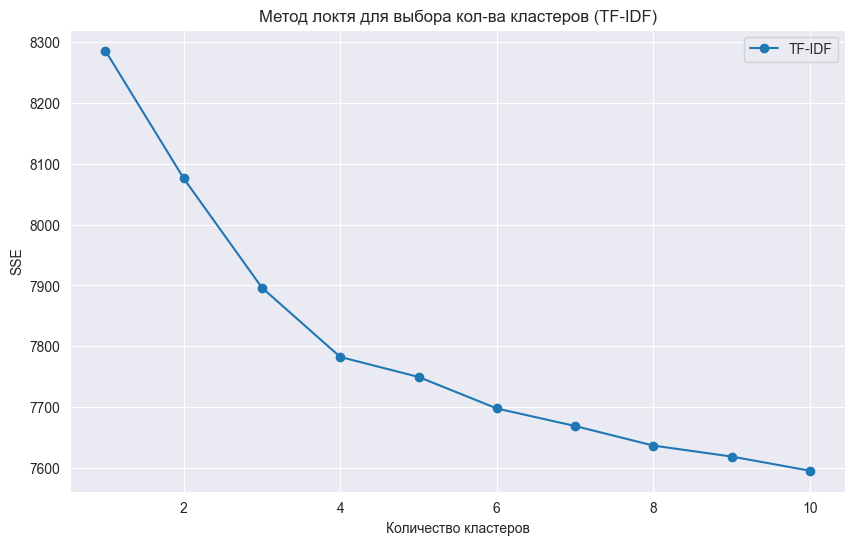

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(k_range_tfidf, sse_tfidf, marker='o', label='TF-IDF')
plt.xlabel('Количество кластеров')
plt.ylabel('SSE')
plt.title('Метод локтя для выбора кол-ва кластеров (TF-IDF)')
plt.legend()
plt.show()

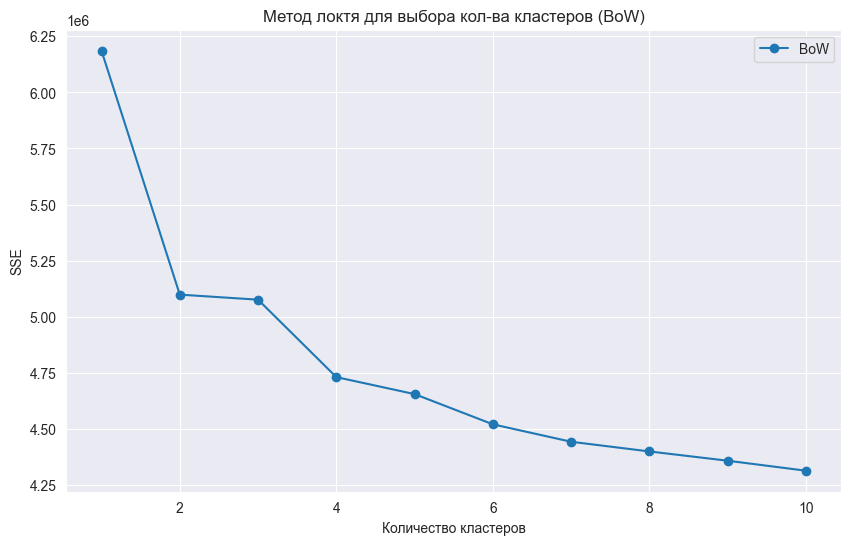

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(k_range_bof, sse_bof, marker='o', label='BoW')
plt.xlabel('Количество кластеров')
plt.ylabel('SSE')
plt.title('Метод локтя для выбора кол-ва кластеров (BoW)')
plt.legend()
plt.show()

In [77]:
from sklearn.model_selection import train_test_split

X_train_BoW, X_test_BoW = train_test_split(df_vr1_vectorized, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf = train_test_split(df_vr2_vectorized, test_size=0.2, random_state=42)

optim_k = 6
kmeans_model_BoW = KMeans(n_clusters=optim_k, random_state=42)
kmeans_model_BoW.fit(X_train_BoW)

KMeans(n_clusters=6, random_state=42)

In [78]:
kmeans_model_BoW.fit(X_train_BoW)
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X_train_pred_BoW = kmeans_model_BoW.predict(X_train_BoW)
X_test_pred_BoW = kmeans_model_BoW.predict(X_test_BoW)

X_train_BoW_dense = X_train_BoW.toarray()
X_test_BoW_dense = X_test_BoW.toarray()

silhouette_score_train = silhouette_score(X_train_BoW_dense, X_train_pred_BoW)
davies_bouldin_score_train = davies_bouldin_score(X_train_BoW_dense, X_train_pred_BoW)
calinski_harabasz_score_train = calinski_harabasz_score(X_train_BoW_dense, X_train_pred_BoW)

silhouette_score_test = silhouette_score(X_test_BoW_dense, X_test_pred_BoW)
davies_bouldin_score_test = davies_bouldin_score(X_test_BoW_dense, X_test_pred_BoW)
calinski_harabasz_score_test = calinski_harabasz_score(X_test_BoW_dense, X_test_pred_BoW)

print('k-means trained on BoW:')
print('-' * 35)
print(
    f'Silhouette score training: {silhouette_score_train:.3f}\n'
    f'Davies Bouldin training: {davies_bouldin_score_train:.3f}\n'
    f'Calinski-Harabasz Index training: {calinski_harabasz_score_train:.3f}')
print('-' * 35)
print(
    f'Silhouette score testing: {silhouette_score_test:.3f}\n'
    f'Davies Bouldin testing: {davies_bouldin_score_test:.3f}\n'
    f'Calinski-Harabasz Index testing: {calinski_harabasz_score_test:.3f}')

k-means trained on BoW:
-----------------------------------
Silhouette score training: 0.276
Davies Bouldin training: 2.557
Calinski-Harabasz Index training: 544.637
-----------------------------------
Silhouette score testing: 0.290
Davies Bouldin testing: 2.963
Calinski-Harabasz Index testing: 196.203


In [79]:
kmeans_model_tfidf = KMeans(n_clusters=optim_k, random_state=42)
kmeans_model_tfidf.fit(X_train_tfidf)

X_train_pred_tfidf = kmeans_model_tfidf.predict(X_train_tfidf)
X_test_pred_tfidf = kmeans_model_tfidf.predict(X_test_tfidf)

X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

silhouette_score_train = silhouette_score(X_train_tfidf_dense, X_train_pred_tfidf)
davies_bouldin_score_train = davies_bouldin_score(X_train_tfidf_dense, X_train_pred_tfidf)
calinski_harabasz_score_train = calinski_harabasz_score(X_train_tfidf_dense, X_train_pred_tfidf)

silhouette_score_test = silhouette_score(X_test_tfidf_dense, X_test_pred_tfidf)
davies_bouldin_score_test = davies_bouldin_score(X_test_tfidf_dense, X_test_pred_tfidf)
calinski_harabasz_score_test = calinski_harabasz_score(X_test_tfidf_dense, X_test_pred_tfidf)

print('k-means trained on TF-IDF:')
print('-' * 35)
print(
      f'Silhouette score training: {silhouette_score_train:.3f}\n'
      f'Davies Bouldin training: {davies_bouldin_score_train:.3f}\n'
      f'Calinski-Harabasz Index training: {calinski_harabasz_score_train:.3f}')
print('-' * 35)
print(
      f'Silhouette score testing: {silhouette_score_test:.3f}\n'
      f'Davies Bouldin testing: {davies_bouldin_score_test:.3f}\n'
      f'Calinski-Harabasz Index testing: {calinski_harabasz_score_test:.3f}')

k-means trained on TF-IDF:
-----------------------------------
Silhouette score training: 0.033
Davies Bouldin training: 6.956
Calinski-Harabasz Index training: 101.887
-----------------------------------
Silhouette score testing: 0.035
Davies Bouldin testing: 6.700
Calinski-Harabasz Index testing: 27.033


In [80]:
morph = pymorphy3.MorphAnalyzer()

def lemmatize_with_pymorphy(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return ' '.join(morph.parse(word)[0].normal_form for word in words)

In [81]:
texts = news_data['content_lem'].dropna()
lemmatized_texts = texts.swifter.apply(lemmatize_with_pymorphy)


# Сохраняем в pickle
with open("lemmatized_texts.pkl", "wb") as f:
    pickle.dump(lemmatized_texts, f)

Pandas Apply:   0%|          | 0/8607 [00:00<?, ?it/s]

In [82]:
# Загружаем из pickle
with open("lemmatized_texts.pkl", "rb") as f:
    lemmatized_texts = pickle.load(f)

In [83]:
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(lemmatized_texts)

from scipy.sparse import save_npz

# Сохраняем векторизатор
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Сохраняем разреженную матрицу
save_npz("bow_matrix.npz", bow_matrix)

In [84]:
from scipy.sparse import load_npz

# Загружаем векторизатор
with open("vectorizer.pkl", "rb") as f:
    loaded_vectorizer = pickle.load(f)

# Загружаем разреженную матрицу
loaded_bow_matrix = load_npz("bow_matrix.npz")

In [85]:
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

bow_df.index = bow_df.index + 1

bow_df.to_csv('bow_output.csv', index=True, index_label='id', sep=";")

In [86]:
news_data['text'] =news_data['title'] + '. ' + news_data['content_lem']
news_data.loc[:, 'text'] = news_data['text'].apply(lambda x: str(x).lower())

lemmatized_texts = texts.apply(lemmatize_with_pymorphy)

vectorizer = CountVectorizer()
bow_matrix_not_dropna = vectorizer.fit_transform(lemmatized_texts)

In [87]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(bow_matrix_not_dropna)

silhouette_avg = silhouette_score(bow_matrix_not_dropna, clusters)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.29


In [88]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(bow_matrix_not_dropna)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx+1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic #1:
год, млрд, рубль, компания, млн, составить, руб, квартал, также, тыс
Topic #2:
год, акция, рост, компания, рубль, рынок, цена, бумага, уровень, ставка
Topic #3:
банк, это, ставка, рынок, который, эксперт, год, цб, инвестор, россия
Topic #4:
год, компания, российский, россия, который, страна, нефть, рф, сша, также
Topic #5:
россия, который, год, это, сигнал, медуза, тот, человек, работать, по


In [89]:
num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(bow_matrix)

In [90]:
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(bow_matrix.toarray())

In [91]:
plot_data = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
plot_data['Cluster'] = clusters

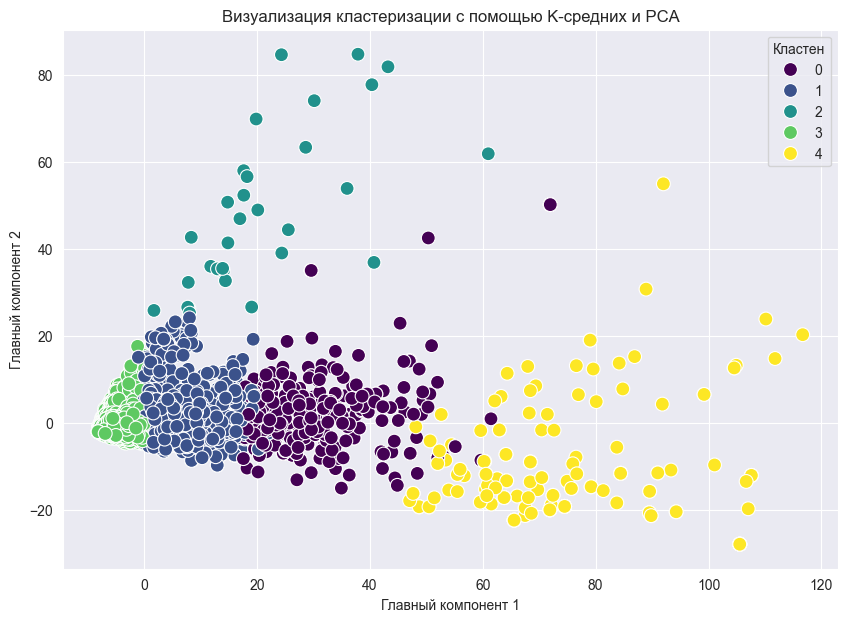

In [92]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=plot_data, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100)
plt.title('Визуализация кластеризации с помощью K-средних и PCA')
plt.xlabel('Главный компонент 1')
plt.ylabel('Главный компонент 2')
plt.legend(title='Кластен')
plt.grid(True)
plt.show()

In [93]:
word_frequencies = bow_df.sum(axis=0).sort_values(ascending=False)

In [94]:
top_n = 50
top_words = word_frequencies.head(top_n)

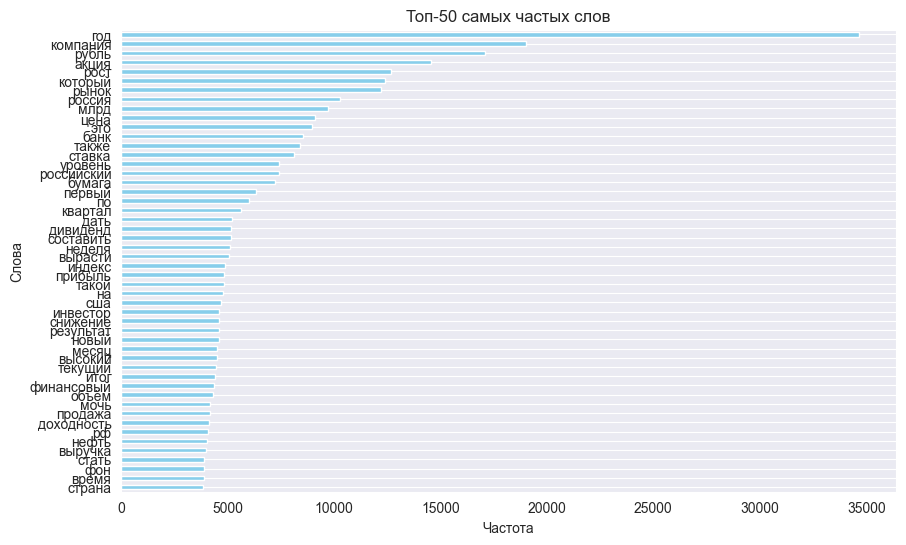

In [95]:
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.title('Топ-50 самых частых слов')
plt.xlabel('Частота')
plt.ylabel('Слова')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

In [96]:
news_data['date'] = pd.to_datetime(news_data['date'], format='%m/%d/%y %H:%M', errors='coerce')
word_over_time = bow_df[top_words.index].groupby(news_data['date'].dt.to_period('M')).sum()

<Figure size 1200x600 with 0 Axes>

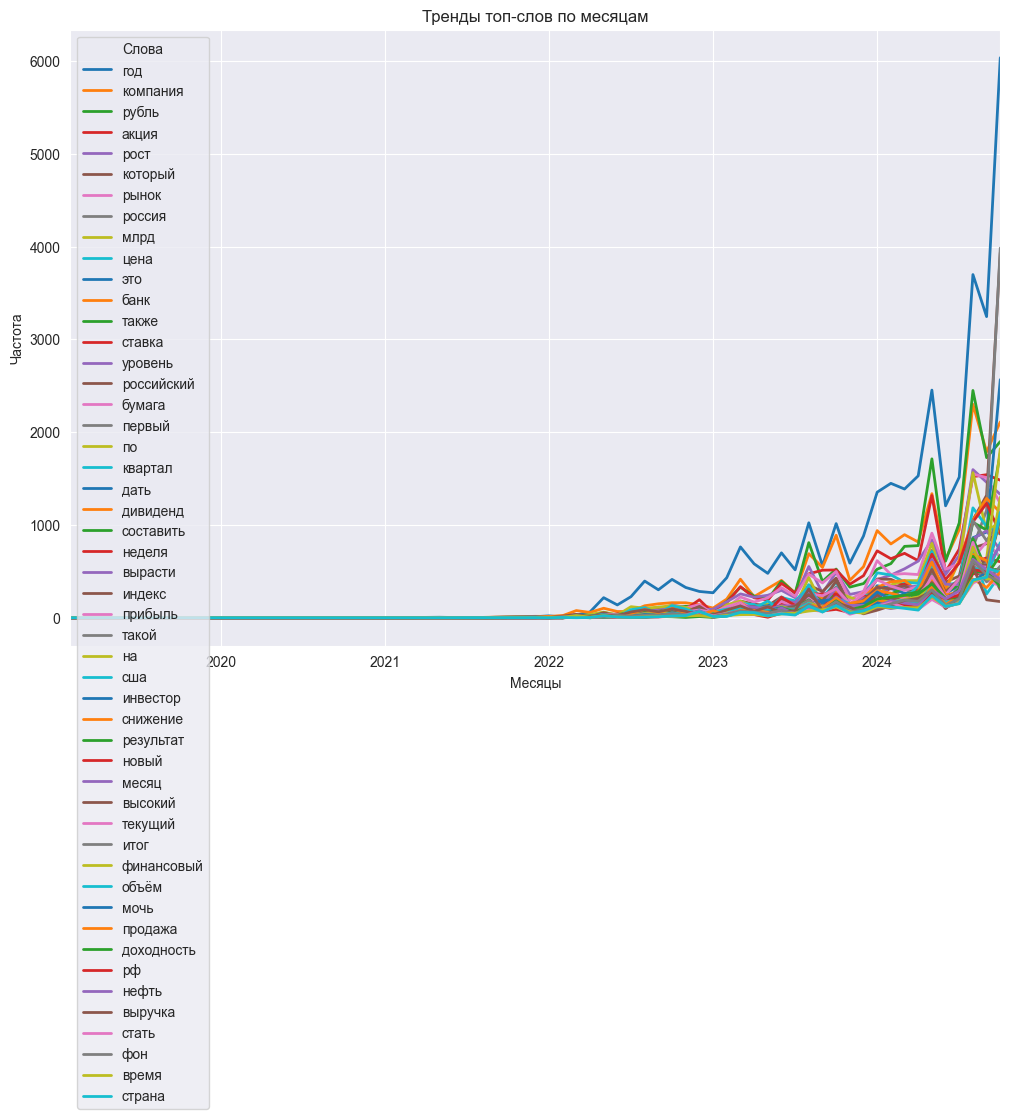

In [97]:
plt.figure(figsize=(12, 6))
word_over_time.plot(figsize=(12, 8), linewidth=2)
plt.title('Тренды топ-слов по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Частота')
plt.legend(title='Слова')
plt.grid(True)
plt.show()

In [98]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_texts)

In [99]:
doc_index = 0
tfidf_scores = pd.Series(tfidf_matrix[doc_index].toarray().flatten(), index=tfidf_vectorizer.get_feature_names_out())
top_tfidf_words = tfidf_scores.sort_values(ascending=False).head(10)

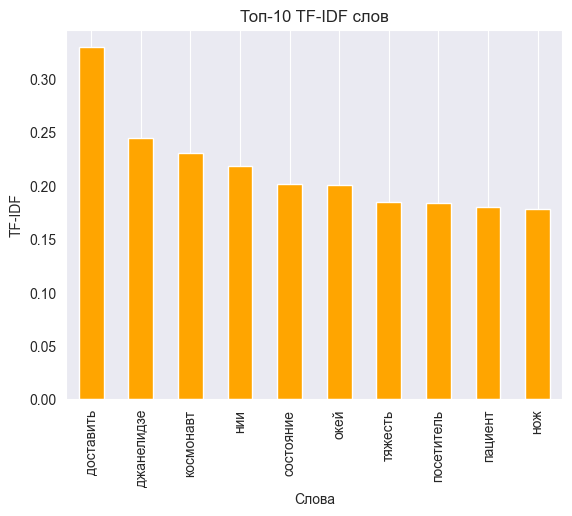

In [100]:
top_tfidf_words.plot(kind='bar', color='orange')
plt.title(f'Топ-10 TF-IDF слов')
plt.xlabel('Слова')
plt.ylabel('TF-IDF')
plt.grid(axis='y')
plt.show()

In [1]:
!pip install transformers torch sentencepiece -q

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Загрузка модели RuBERT
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

# Проверка на наличие GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Токенизация с использованием RuBERT
def preprocess_and_tokenize(text, tokenizer, max_length=128):
    tokens = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return tokens

news_data["tokens"] = news_data["content_lem"].apply(lambda x: preprocess_and_tokenize(x, tokenizer))

In [9]:
def generate_embeddings(tokens, model):
    with torch.no_grad():
        tokens = {key: val.to(device) for key, val in tokens.items()}
        outputs = model(**tokens)
        # Используем эмбеддинг CLS токена
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings

# Генерация эмбеддингов для всех текстов
news_data["embeddings"] = news_data["tokens"].apply(lambda x: generate_embeddings(x, model))
embeddings = np.vstack(news_data["embeddings"].values)

In [21]:
# Кластеризация текстов с помощью KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Сохранение кластеров в данные
news_data["cluster"] = clusters

In [22]:
# Вычисление метрик кластеризации
sil_score = silhouette_score(embeddings, clusters)
db_score = davies_bouldin_score(embeddings, clusters)

print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Score: {db_score}")

Silhouette Score: 0.09846770763397217
Davies-Bouldin Score: 2.692963680392415


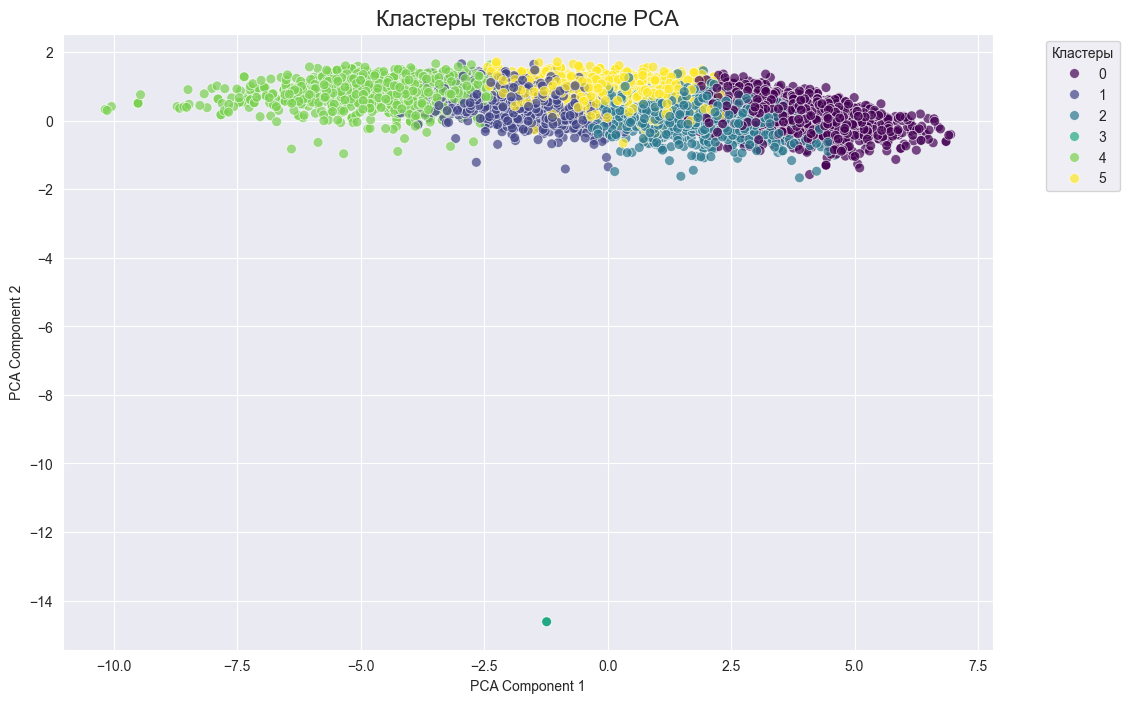

In [23]:
# Уменьшение размерности с помощью PCA до 2D
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

# Добавление координат в DataFrame
news_data["x"] = reduced_embeddings[:, 0]
news_data["y"] = reduced_embeddings[:, 1]

# Визуализация кластеров
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="x", y="y", hue="cluster", data=news_data, palette="viridis", s=50, alpha=0.7
)
plt.title("Кластеры текстов после PCA", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Кластеры", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

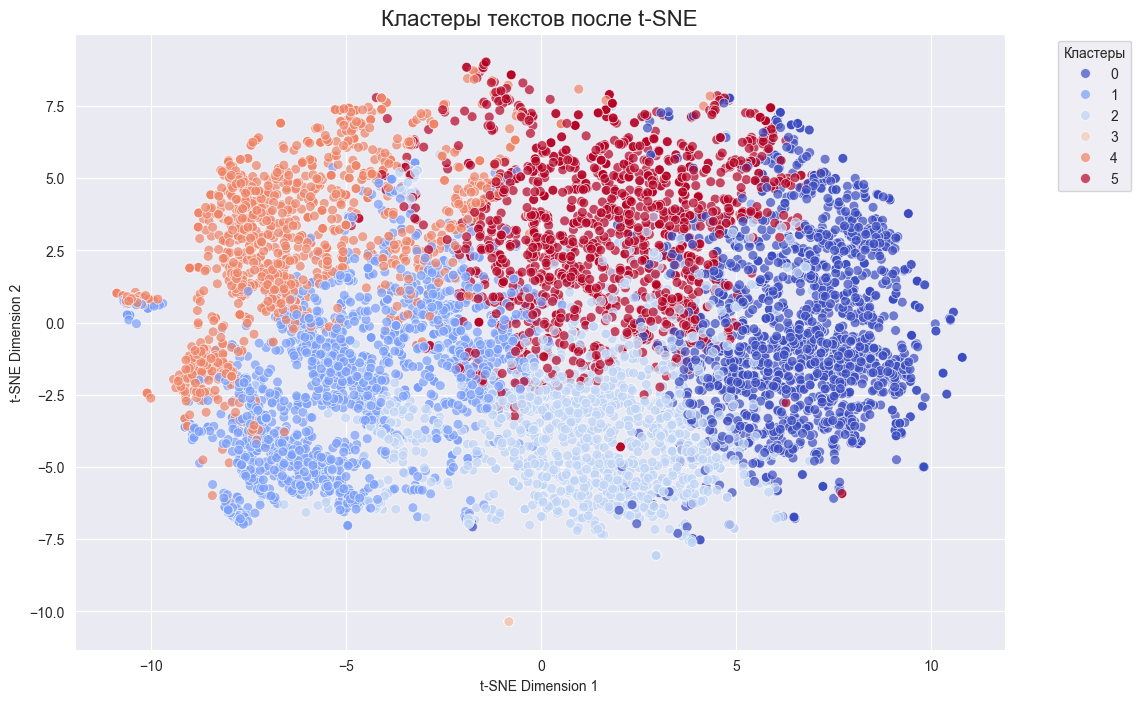

In [24]:
from sklearn.manifold import TSNE

# Уменьшение размерности с помощью t-SNE до 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(embeddings)

# Добавление координат в DataFrame
news_data["tsne_x"] = tsne_embeddings[:, 0]
news_data["tsne_y"] = tsne_embeddings[:, 1]

# Визуализация кластеров
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne_x", y="tsne_y", hue="cluster", data=news_data, palette="coolwarm", s=50, alpha=0.7
)
plt.title("Кластеры текстов после t-SNE", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Кластеры", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

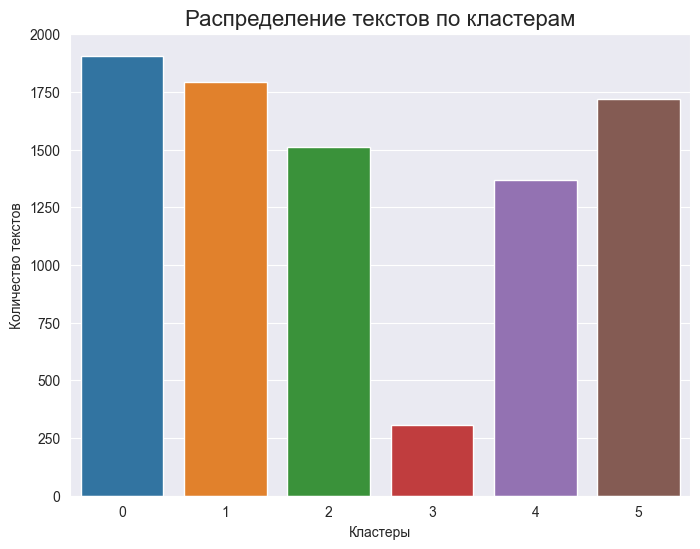

In [25]:
# Гистограмма распределения
plt.figure(figsize=(8, 6))
sns.countplot(x="cluster", data=news_data, palette="tab10")
plt.title("Распределение текстов по кластерам", fontsize=16)
plt.xlabel("Кластеры")
plt.ylabel("Количество текстов")
plt.show()

In [26]:
# Пример по кластерам
for cluster_id in news_data["cluster"].unique():
    print(f"\n=== Кластер {cluster_id} ===")
    cluster_texts = news_data[news_data["cluster"] == cluster_id]["content_lem"]
    
    # Проверяем наличие текстов в кластере
    if len(cluster_texts) > 0:
        sample_texts = cluster_texts.sample(min(5, len(cluster_texts)), random_state=42)
        for i, text in enumerate(sample_texts, 1):
            print(f"{i}. {text[:200]}...")
    else:
        print("Нет текстов в этом кластере.")


=== Кластер 4 ===
1. анонсировать новый накопитель предназначить задача связанный искусственный интеллект заявить скорость последовательный чтение накопитель составлять мбайт последовательный запись мбайт цена новый устро...
2. кадр вчерашний взрыв газ стерлитамак который пострадать несколько человек видно пламя накрывать пробегать мимо рабочий проезжать фура...
3. в конец сентябрь роскомнадзор вынести пять решений нарушение российский законодательство отношение мессенджер в ведомство заявить потребовать платформа удалить тысяча материал который ркн считать пр...
4. аудиоверсия текст слушайт «радио медуза»«ть первый день вторжение мир перевернуться произойти катастрофа невероятный масштаб говорить катерина сергацков украинский журналистка директор организация ж...
5. авто официально снять видео представить официальный видеотизер обновить кроссовер который появиться продажа ноябрь на тизер показать вертикальный дхо который вкупе изменить решётка радиатор сделать пе...

=== Кластер 

In [27]:
from collections import Counter
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words("russian")) | set(string.punctuation)

# Функция для извлечения частотных слов в кластере
def get_top_words(texts, top_n=10):
    all_words = " ".join(texts).split()
    filtered_words = [word.lower() for word in all_words if word.lower() not in stop_words]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(top_n)

# Вывод ключевых слов для каждого кластера
for cluster_id in news_data["cluster"].unique():
    cluster_texts = news_data[news_data["cluster"] == cluster_id]["content_lem"]
    top_words = get_top_words(cluster_texts, top_n=10)
    print(f"\n=== Кластер {cluster_id} ===")
    print("Основные темы (частотные слова):")
    for word, count in top_words:
        print(f"{word}: {count}")


=== Кластер 4 ===
Основные темы (частотные слова):
год: 1809
который: 932
россия: 930
рубль: 834
это: 775
компания: 641
млрд: 543
также: 530
•: 475
российский: 450

=== Кластер 0 ===
Основные темы (частотные слова):
год: 14114
компания: 8257
акция: 7523
рост: 7302
рубль: 6866
рынок: 5413
цена: 4910
г: 4669
ставка: 4445
уровень: 4268

=== Кластер 1 ===
Основные темы (частотные слова):
год: 4019
который: 2579
россия: 2260
это: 2069
также: 1302
компания: 1229
«сигнал»: 1195
страна: 1114
рф: 1013
работать: 1009

=== Кластер 2 ===
Основные темы (частотные слова):
год: 5542
компания: 3586
который: 2172
рубль: 1938
россия: 1765
банк: 1632
акция: 1520
российский: 1514
млрд: 1349
также: 1325

=== Кластер 5 ===
Основные темы (частотные слова):
год: 9094
рубль: 6441
компания: 5182
акция: 4786
рынок: 4644
рост: 3739
млрд: 3243
–: 3060
цена: 2816
банк: 2729

=== Кластер 3 ===
Основные темы (частотные слова):


In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Функция для извлечения частотных биграмм
def get_top_bigrams(texts, top_n=10):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=list(stop_words))
    bigrams_matrix = vectorizer.fit_transform(texts)
    bigram_counts = bigrams_matrix.sum(axis=0)
    bigrams = vectorizer.get_feature_names_out()
    bigram_frequencies = [(bigrams[i], bigram_counts[0, i]) for i in range(len(bigrams))]
    return sorted(bigram_frequencies, key=lambda x: x[1], reverse=True)[:top_n]

# Вывод биграмм для каждого кластера
for cluster_id in news_data["cluster"].unique():
    cluster_texts = news_data[news_data["cluster"] == cluster_id]["content_lem"]
    top_bigrams = get_top_bigrams(cluster_texts, top_n=10)
    print(f"\n=== Кластер {cluster_id} ===")
    print("Основные темы (биграммы):")
    for bigram, count in top_bigrams:
        print(f"{bigram}: {count}")


=== Кластер 4 ===
Основные темы (биграммы):
россии ский: 299
млрд рубль: 282
пока россия: 214
понимать новость: 213
условие использование: 213
защита спам: 212
имеи ть: 212
интернет защита: 212
использование подробный: 212
конфиденциальность условие: 212

=== Кластер 0 ===
Основные темы (биграммы):
млрд рубль: 2406
чистый прибыль: 1325
ключевой ставка: 1155
год год: 1092
первый полугодие: 1051
ценный бумага: 1043
банк россия: 932
второй квартал: 826
индекс мосбиржа: 754
квартал год: 728

=== Кластер 1 ===
Основные темы (биграммы):
пора пока: 605
имеи ть: 598
помогать понимать: 598
ть рассылка: 598
защита спам: 597
интернет защита: 597
использование подробный: 597
конфиденциальность условие: 597
медузы помогать: 597
новость работать: 597

=== Кластер 2 ===
Основные темы (биграммы):
млрд рубль: 728
банк россия: 320
пресс служба: 290
говориться сообщение: 230
конец год: 226
чистый прибыль: 226
совет директор: 224
год год: 207
ценный бумага: 203
составить млрд: 200

=== Кластер 5 ===
Осно

ValueError: empty vocabulary; perhaps the documents only contain stop words